<a href="https://colab.research.google.com/github/borisbrodski/py-interplanetary-simulator/blob/master/StarKicker%20-%20cutting%20down%20on%20travel%20time%20to%20Mars/Calculate_mission_profile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# StarKicker - cutting down on travel time to Mars


<p style="text-align: right">by Boris Brodski <brodsky_boris@yahoo.com></p>

![starship](https://github.com/borisbrodski/py-interplanetary-simulator/raw/6f1ab956e9441f9a9d54ff45754bcd501b9d0eed/images/StarKicker-detached-small.jpg)

[Rendering in 4K](https://github.com/borisbrodski/py-interplanetary-simulator/raw/6f1ab956e9441f9a9d54ff45754bcd501b9d0eed/images/StarKicker-detached.jpg)

# What is StarKicker

The idea is to use a special desiged Starship (called here StarKicker) to provide additional Delta V to the departing to mars crewed Starship. Once launched, the StarKicker will always stay in orbit. The StarKicker is basen on expendable version of SpaceX's Starship but needs neither the nosecone nor the cargo bay. Both the nosecone and the cargo bay should be ditched during the launch. It utilize standard 9m ring docking port, that is used to connect SuperHeavy with the StarShip on accent from earth.

Operation outline:

* Fully fuelled StarKicker docks with the departing StarShip
* StarKicker burns a large amount of fuel giving additional delta V to the departing Starship
* After the "kick burn" both Starships separate
* The StarKicker rotates 180° and burns retrograde to return to its original orbit
  * Optionally, StarKicker may return to higher elliptical orbit an use aerobreaking to reduce speed
* StarKicker gets refuelled in orbit
* StarKicker is ready for reuse

# What is the goal of the Notebook

The goal of this notebook is to calculate exact travel trajectories and times in order to understand the benefit of the StarKicker in terms of reducing travel time.

# Notebook structure

This notebook consists of the following parts:

* **Global definitions and imports**
  * Define nature constants
  * import python libraries
* **BSP solar system data from NASA**
  * Loading BSP-file from https://naif.jpl.nasa.gov
  * Providing methods to get solar system body locations and velocities
* **Plots**
  * Implements 3D and 2D ploting methods using `matplotlib.pyplot`
* **Mission profile**
  * Classes for mission profile definition
  * Specifies starting point and velocity, planned burns and separation events
* **Simulation**
  * Simulates StarShip flight according to the mission profile
  * Uses `scipy.integrate.ode` differential equation solver for possition, velocity and mass
  * Saves and returns flight data (`simulation_data` dict)
* **Optimizer**
  * Uses function optimizer `scipy.optimize.minimize` to find optimal trajectory
* **Tests**
  * Uses `pytest` to unit-test the methods and classes

# Python

## Download packages (colab only)

In [ ]:
%pip install jplephem 'pytest==5.4.3' pytest-sugar ipytest

## Global definitions

**Python imports**

In [ ]:
from typing import List, Tuple

import math
import datetime
import numpy as np

from scipy.integrate import ode
from scipy.spatial.transform import Rotation
from scipy.optimize import minimize

from timeit import default_timer as timer

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from jplephem.spk import SPK # https://pypi.org/project/jplephem/

import pytest
import ipytest
ipytest.autoconfig(raise_on_error = True)

np.set_printoptions(precision=10)
#np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

/usr/local/lib/python3.6/dist-packages/ipytest/_unittest_support.py:18: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as _pd_testing


**Constants**

In [ ]:
# Celestial bodies
# (See de421.bsp)
SUN=0
MERCURY=1
VENUS=2
EARTH=3
MARS=4
JUPITER=5
SATURN=6
URANUS=7
NEPTUNE=8

PLANETS=[EARTH, MARS, JUPITER]
BODIES=[SUN] + PLANETS

ALL_PLANETS=[MERCURY, VENUS, EARTH, MARS, JUPITER, SATURN, URANUS, NEPTUNE]
ALL_BODIES=[SUN] + ALL_PLANETS

# Standard gravitational parameter
MU_EARTH=398600.4418 # m^3/s^2
MU_MARS=42828.37
MU_SUN=1.32712440018e11
MU_JUPITER=1.26686534e8 #e8

MU = {SUN: MU_SUN, EARTH: MU_EARTH, MARS: MU_MARS, JUPITER: MU_JUPITER}


G_EARTH=9.80665e-3 # km/sec^2
R_EARTH=6378.0 # km at equator
R_MARS=3396.2 # km at equator

ORBITAL_PERIOD = {
    SUN: 1,
    MERCURY: 88,
    VENUS: 225,
    EARTH: 366,
    MARS: 687,
    JUPITER: 4333,
    SATURN: 10759,
    URANUS: 30688 ,
    NEPTUNE: 60182,
}

# StarShip data
RAPTOR_SPECIFIC_IMPULSE=382  # https://en.wikipedia.org/wiki/SpaceX_Raptor
RAPTOR_FLOW_RATE=0.9312 # Ton/sec, https://spaceflight101.com/spx/spacex-raptor/ 

STARKICKER_RAPTOR_COUNT=3
STARSHIP_RAPTOR_COUNT=3

## Util methods

In [ ]:
class PrettyPrintable:
    """Enable pretty printing of the class attributes"""
    def __repr__(self):
        return pretty_write_dict(self.__dict__)
            
def pretty_write_dict(dictionary):
    def _nested(obj, level=1):
        indentation_values = "\t" * level
        indentation_braces = "\t" * (level - 1)
        if isinstance(obj, PrettyPrintable):
            obj = obj.__dict__
        if isinstance(obj, dict):
            return "{\n%(body)s%(indent_braces)s}" % {
                "body": "".join("%(indent_values)s\'%(key)s\': %(value)s,\n" % {
                    "key": str(key),
                    "value": _nested(value, level + 1),
                    "indent_values": indentation_values
                } for key, value in obj.items()),
                "indent_braces": indentation_braces
            }
        if isinstance(obj, list):
            return "[\n%(body)s\n%(indent_braces)s]" % {
                "body": "".join("%(indent_values)s%(value)s,\n" % {
                    "value": _nested(value, level + 1),
                    "indent_values": indentation_values
                } for value in obj),
                "indent_braces": indentation_braces
            }
        else:
            return "\'%(value)s\'" % {"value": str(obj)}

    dict_text = _nested(dictionary)
    return dict_text

def self_assign(self, vars_to_add):
    self.__dict__.update(l for l in vars_to_add.items() if l[0] != 'self')

In [ ]:
def get_julian_datetime(date):
    """
    Convert a datetime object into julian float.
    Args:
        date: datetime-object of date in question

    Returns: float - Julian calculated datetime.
    Raises: 
        TypeError : Incorrect parameter type
        ValueError: Date out of range of equation
    """

    # Ensure correct format
    if not isinstance(date, datetime.datetime):
        raise TypeError('Invalid type for parameter "date" - expecting datetime')
    elif date.year < 1801 or date.year > 2099:
        raise ValueError('Datetime must be between year 1801 and 2099')

    # Perform the calculation
    julian_datetime = 367 * date.year - int((7 * (date.year + int((date.month + 9) / 12.0))) / 4.0) + int(
        (275 * date.month) / 9.0) + date.day + 1721013.5 + (
                          date.hour + date.minute / 60.0 + date.second / math.pow(60,
                                                                                  2)) / 24.0 - 0.5 * math.copysign(
        1, 100 * date.year + date.month - 190002.5) + 0.5

    return julian_datetime

## Jet Propulsion Laboratory's SPK files

Load Jet Propulsion Laboratory (JPL) ephemeris for predicting the position and velocity of a planet or other Solar System body.

* https://pypi.org/project/jplephem/
* https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/

In [ ]:
!wget https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/a_old_versions/de421.bsp

--2020-07-10 10:57:58--  https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/a_old_versions/de421.bsp
Resolving naif.jpl.nasa.gov (naif.jpl.nasa.gov)... 137.78.232.95
Connecting to naif.jpl.nasa.gov (naif.jpl.nasa.gov)|137.78.232.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16790528 (16M) [text/plain]
Saving to: ‘de421.bsp.5’

de421.bsp.5         100%[===================>]  16.01M  8.67MB/s    in 1.8s    

2020-07-10 10:58:00 (8.67 MB/s) - ‘de421.bsp.5’ saved [16790528/16790528]



In [ ]:
kernel = SPK.open('de421.bsp')
print(kernel)
KERNEL_ID={
    MERCURY: 1,
    VENUS: 2,
    EARTH: 3,
    MARS: 4,
    JUPITER: 5,
    SATURN: 6,
    URANUS: 7,
    NEPTUNE: 8,
    SUN: 10
}



File type DAF/SPK and format LTL-IEEE with 15 segments:
2414864.50..2471184.50  Solar System Barycenter (0) -> Mercury Barycenter (1)
2414864.50..2471184.50  Solar System Barycenter (0) -> Venus Barycenter (2)
2414864.50..2471184.50  Solar System Barycenter (0) -> Earth Barycenter (3)
2414864.50..2471184.50  Solar System Barycenter (0) -> Mars Barycenter (4)
2414864.50..2471184.50  Solar System Barycenter (0) -> Jupiter Barycenter (5)
2414864.50..2471184.50  Solar System Barycenter (0) -> Saturn Barycenter (6)
2414864.50..2471184.50  Solar System Barycenter (0) -> Uranus Barycenter (7)
2414864.50..2471184.50  Solar System Barycenter (0) -> Neptune Barycenter (8)
2414864.50..2471184.50  Solar System Barycenter (0) -> Pluto Barycenter (9)
2414864.50..2471184.50  Solar System Barycenter (0) -> Sun (10)
2414864.50..2471184.50  Earth Barycenter (3) -> Moon (301)
2414864.50..2471184.50  Earth Barycenter (3) -> Earth (399)
2414864.50..2471184.50  Mercury Barycenter (1) -> Mercury (199)
241486

In [ ]:
def get_body_xyz(body, julian_datetime):
    return kernel[0,KERNEL_ID[body]].compute(julian_datetime)
#print(get_body_xyz(MARS, 2457061.5))

In [ ]:
def get_body_r_v(body, julian_datetime):
    position, velocity = kernel[0,KERNEL_ID[body]].compute_and_differentiate(julian_datetime)
    return np.concatenate([position,velocity / 86400.0])

print(get_body_r_v(EARTH, 2457061.5))

[-1.1036988987e+08  8.9306959522e+07  3.8693188573e+07 -2.0147016205e+01
 -2.0620627574e+01 -8.9394402932e+00]


In [ ]:
def get_orbits(start_date, planets = PLANETS, resolution_in_days = 10):
    orbits = {}
    for planet in planets:
        length = ORBITAL_PERIOD[planet] // resolution_in_days
        orbit = np.zeros((length, 3))
        orbits[planet] = orbit
        for i in range(length):
            date = start_date + datetime.timedelta(days=i * resolution_in_days)
            julian_datetime = get_julian_datetime(date)
            orbit[i, :] = kernel[0,KERNEL_ID[planet]].compute(julian_datetime)

    return orbits

In [ ]:
def draw_orbits(*orbits_args, focus_point=None, focus_distance=None, interactive=False):
    if interactive:
        %matplotlib notebook
        fig = plt.figure(figsize=(6, 6))
    else:
        %matplotlib inline
        fig = plt.figure(figsize=(18, 9))

    i = 1
    for angles in [(50, -70), (45, 45)]:
        ax = fig.add_subplot(1, 2, i, projection='3d')
        plt.subplots_adjust(left = 0, right = 1)
        fig.tight_layout()
        i += 1
        ax.view_init(*angles)

        for orbit_arg in orbits_args:
            if isinstance(orbit_arg, dict):
                orbits = orbit_arg
                for body in orbits:
                    orbit = orbits[body]
                    name = "Body " + str(body)
                    points = orbit
                    if focus_point is not None:
                        points = points[ np.linalg.norm(points - focus_point[np.newaxis, :], axis=1) < focus_distance , :]
                    ax.plot3D(points[:,0], points[:,1], points[:,2], label = name)
                    #ax.scatter3D(orbit[0, 0], orbit[0, 1], orbit[0, 2], 'C3')
                    #ax.scatter3D(orbit[-1, 0], orbit[-1, 1], orbit[-1, 2], 'C4')
            else:
                orbit = orbit_arg
                points = orbit
                if focus_point is not None:
                    points = points[ np.linalg.norm(points - focus_point[np.newaxis, :], axis=1) < focus_distance , :]
                ax.scatter3D(points[:, 0], points[:, 1], points[:, 2], 'C2', label = "Orbit")

    plt.legend()
    plt.show()

#    plt.figure()
#    plt.plot(mars_xs, mars_ys)
#    plt.plot(earth_xs, earth_ys)
#    plt.show()
#
#    plt.figure()
#    plt.plot(mars_ys, mars_zs)
#    plt.plot(earth_ys, earth_zs)
#    plt.show()
#
#    plt.figure()
#    plt.plot(mars_xs, mars_zs)
#    plt.plot(earth_xs, earth_zs)
#    plt.show()

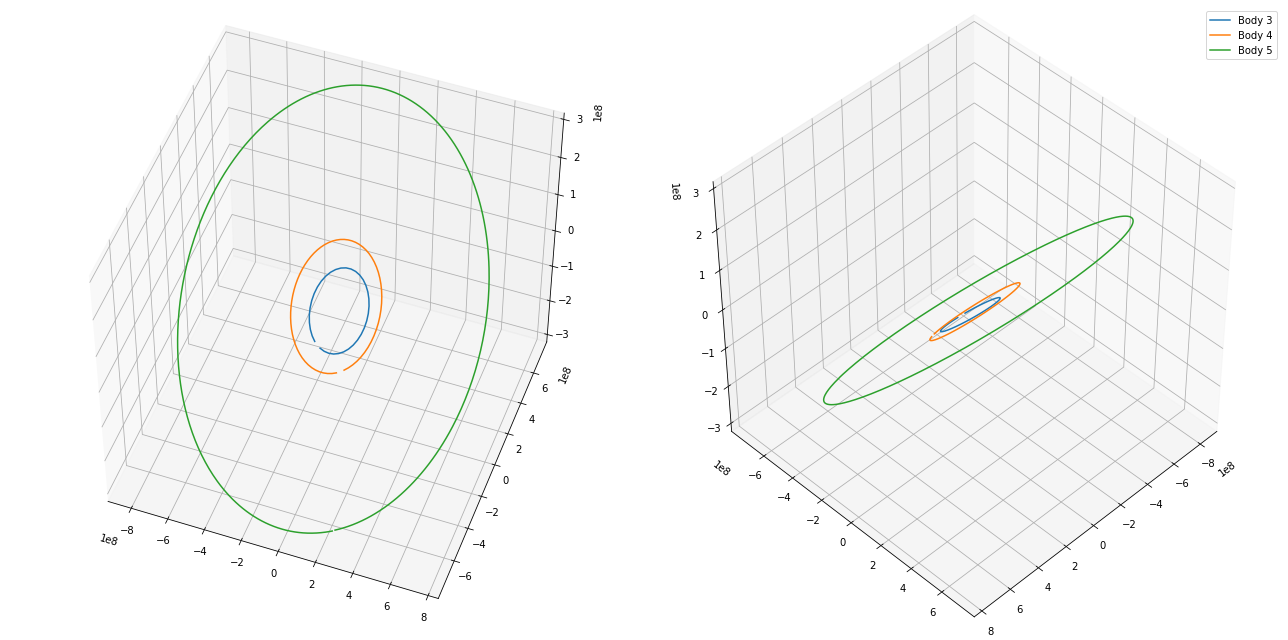

In [ ]:
orbits = get_orbits(datetime.datetime(2020, 6, 1))
draw_orbits(orbits)
#draw_orbits(orbits, focus_point=orbits[EARTH][0], focus_distance=100000000)

## Mission profile

In [ ]:
class Event(PrettyPrintable):
    pass

class InstantaneousEvent(Event):
    pass

class ContinuousEvent(Event):
    def calculate_or_get_duration(self, m):
        return self.duration

class Burn(ContinuousEvent):
    def __init__(self,
                 t,                              # Time of event (seconds since t0)
                 duration = None,                # Duration of the burn (seconds)
                 delta_v = None,                 # Intended delta v
                 angle_orbital_plane = 0,        # Angle to v in orbital plane (in °)
                 angle_orbital_plane_normal = 0, # Angle to v perpendicular to orbital plane (in °)
                 flow_rate = RAPTOR_FLOW_RATE * STARSHIP_RAPTOR_COUNT,
                 specific_impulse = RAPTOR_SPECIFIC_IMPULSE):
        self_assign(self, locals())
        assert (duration is not None) != (delta_v is not None), "Please, provide duration or delta_v"
    
    def calculate_or_get_duration(self, m):
        if self.duration is not None:
            return self.duration

        delta_m = m - m / np.exp(self.delta_v / (self.specific_impulse * G_EARTH))

        return delta_m / self.flow_rate

class InstantBurn(InstantaneousEvent):
    def __init__(self,
                 t,                               # Time of event (seconds since t0)
                 delta_v = 0,                     # Intended delta v
                 angle_orbital_plane = 0,         # Angle to v in ecliptic plate (in °)
                 angle_orbital_plane_normal = 0): # Angle to v perpendicular to ecliptic (in °)
        self_assign(self, locals())

class Separation(InstantaneousEvent):
    def __init__(self,
                 t,              # Time of event (seconds since t0)
                 delta_m):       # Change in mass (in kg)
        self_assign(self, locals())

class MissionProfile(PrettyPrintable):
    def __init__(self,
                 timestamp0,              # Date and time of the simulation start
                 v0,                      # Initial orbital velocity (in km)
                 mass0,                   # Star mass of the spacecraft
                 orbit0,                  # Initial orbit height (in km)
                 duration,                # Simulation duration (in seconds)
                 sample_size,             # Maximal amount of data points to be gathered
                 dry_mass = 0,            # Dry mass of the ship
                 sample_dt = 60*60,       # Time intervals for orbital parameter sampling (in seconds)
                 hohmann_diviation_angle=0, # In °
                 bodies = [SUN, EARTH, MARS, JUPITER],
                 events = [],
                 lsoda_nsteps=5000):
        self_assign(self, locals())
        
    def __repr__(self):
        return pretty_write_dict(self.__dict__)



## Simulation

### Event Manager

In [ ]:
class EventManager:
    """Configure simulation intervals according to the configured events
    
    Restrictions:
    
    * Times and durations should be int
    * Only one event per time t is currenty supported
    """
    
    def __init__(self, events: List[Event], initial_mass):
        self._events = events
        self._next = 0
        self._current_event = None
        self._begin_interval = 0
        
        self._verify_events()
        self._complete_end_interval(initial_mass)
    
    def _verify_events(self):
        t = 0
        for event in self._events:
            assert t < event.t or np.isclose(t, event.t)
            
            t = event.t
            if isinstance(event, ContinuousEvent):
                if event.duration is not None:
                    assert event.duration > 0
                    t += event.duration
        
    def _complete_end_interval(self, current_mass):
        self._current_event = None

        if self._next >= len(self._events):
            self._end_interval = None
            return
        
        event = self._events[self._next]
        if self._begin_interval < event.t:
            self._end_interval = event.t
            return

        self._next += 1

        if self._begin_interval == event.t:
            self._current_event = event

        if isinstance(event, ContinuousEvent) and self._begin_interval == event.t:
            duration = event.calculate_or_get_duration(current_mass)
            assert not np.isclose(duration, 0) and duration > 0, "Duration to small or negative: " + str(duration)

            self._end_interval = event.t + duration
            
            if self._next < len(self._events):
                next_t = self._events[self._next].t
                assert self._end_interval < next_t or np.isclose(self._end_interval, next_t), \
                    "Calculated duration " + str(duration) + \
                    " sec. for the continuous burn overlaps with the next event at t=" + str(next_t)
            return

        if self._next < len(self._events):
            next_event = self._events[self._next]
            self._end_interval = next_event.t
        else:
            self._end_interval = None

    def next_interval(self, current_mass) -> bool:
        if self._end_interval is None:
            return False

        self._begin_interval = self._end_interval
        
        self._complete_end_interval(current_mass)
        return True
    
    def current_time_interval(self) -> Tuple[int, int]:
        return (self._begin_interval, self._end_interval)

    def current_instantaneous_event(self) -> InstantaneousEvent:
        if isinstance(self._current_event, InstantaneousEvent):
            return self._current_event

        return None
    
    def current_continuous_event(self) -> ContinuousEvent:
        if isinstance(self._current_event, ContinuousEvent):
            return self._current_event

        return None

In [ ]:
ipytest.clean_tests()
#%%run_pytest[clean] -qq

class TestEventManager:
    class MyInstantaneousEvent(InstantaneousEvent):
        def __init__(self, name, t):
            self.name = name
            self.t = t
    class MyContinuousEvent(ContinuousEvent):
        def __init__(self, name, t, duration):
            self.name = name
            self.t = t
            self.duration = duration

        def calculate_or_get_duration(self, mass):
            if self.duration is not None:
                return self.duration
            return mass * 2

    def test_no_events(self):
        em = EventManager([], 0)
        
        self.assert_state(em, (0, None))
        
    def test_one_instantaneous_event(self):
        em = EventManager([TestEventManager.MyInstantaneousEvent("e1", 3)], 0)

        self.assert_state(em, (0, 3))
        self.assert_state(em, (3, None), instantaneous_event = "e1")

    def test_one_continuous_event(self):
        em = EventManager([TestEventManager.MyContinuousEvent("e1", 3, 10)], 0)

        self.assert_state(em, (0, 3))
        self.assert_state(em, (3, 13), continuous_event = "e1")
        self.assert_state(em, (13, None))

    def test_start_with_instantaneous_event(self):
        em = EventManager([TestEventManager.MyInstantaneousEvent("e1", 1)], 0)

        self.assert_state(em, (0, 1))
        self.assert_state(em, (1, None), instantaneous_event = "e1")

    def test_start_with_continuous_event(self):
        em = EventManager([TestEventManager.MyContinuousEvent("e1", 1, 10)], 0)

        self.assert_state(em, (0, 1))
        self.assert_state(em, (1, 11), continuous_event = "e1")
        self.assert_state(em, (11, None))

    def test_consecutive_events(self):
        em = EventManager([
            TestEventManager.MyContinuousEvent("c1", 3, 5),
            TestEventManager.MyContinuousEvent("c2", 8, 1),
            TestEventManager.MyContinuousEvent("c3", 20, 5),
            TestEventManager.MyInstantaneousEvent("i1", 25)
        ], 0)

        self.assert_state(em, (0, 3))
        self.assert_state(em, (3, 8), continuous_event="c1")
        self.assert_state(em, (8, 9), continuous_event="c2")
        self.assert_state(em, (9, 20))
        self.assert_state(em, (20, 25), continuous_event="c3")
        self.assert_state(em, (25, None), instantaneous_event="i1")

    def test_continuous_event_with_calculated_duration(self):
        em = EventManager([
            TestEventManager.MyContinuousEvent("c1", 10, None),
        ], 0)

        self.assert_state(em, (0, 10), mass = 4) # duration = mass * 2
        self.assert_state(em, (10, 18), continuous_event="c1")
        self.assert_state(em, (18, None))

    def test_continuous_event_with_overlapping_calculated_duration(self):
        with pytest.raises(AssertionError) as e:
            em = EventManager([
                TestEventManager.MyContinuousEvent("c1", 10, None),
                TestEventManager.MyInstantaneousEvent("i1", 16)
            ], 0)

            self.assert_state(em, (0, 10), mass = 4) # duration = mass * 2
        assert str(e.value).splitlines()[0] == "Calculated duration 8 sec. for the continuous " \
            + "burn overlaps with the next event at t=16"

    def test_multiple_events(self):
        em = EventManager([
            TestEventManager.MyContinuousEvent("c1", 3.3, 5.5),
            TestEventManager.MyInstantaneousEvent("i1", 9.9),
            TestEventManager.MyContinuousEvent("c2", 12, 5),
            TestEventManager.MyContinuousEvent("c3", 20, 1),
            TestEventManager.MyInstantaneousEvent("i2", 25),
            TestEventManager.MyInstantaneousEvent("i3", 50)
        ], 0)
        
        self.assert_state(em, (0, 3.3))
        self.assert_state(em, (3.3, 8.8), continuous_event="c1")
        self.assert_state(em, (8.8, 9.9))
        self.assert_state(em, (9.9, 12), instantaneous_event="i1")
        self.assert_state(em, (12, 17), continuous_event="c2")
        self.assert_state(em, (17, 20))
        self.assert_state(em, (20, 21), continuous_event="c3")
        self.assert_state(em, (21, 25))
        self.assert_state(em, (25, 50), instantaneous_event="i2")
        self.assert_state(em, (50, None), instantaneous_event="i3")

    def test_overlapping_events(self):
        with pytest.raises(AssertionError):
            em = EventManager([
                TestEventManager.MyContinuousEvent("c1", 3, 5),
                TestEventManager.MyInstantaneousEvent("i1", 6),
            ], 0)

        with pytest.raises(AssertionError):
            em = EventManager([
                TestEventManager.MyContinuousEvent("c1", 3, 5),
                TestEventManager.MyContinuousEvent("c1", 6, 10),
            ], 0)

    def test_not_sorted(self):
        with pytest.raises(AssertionError):
            em = EventManager([
                TestEventManager.MyContinuousEvent("c1", 10, 5),
                TestEventManager.MyInstantaneousEvent("i1", 6),
            ], 0)
        with pytest.raises(AssertionError):
            em = EventManager([
                TestEventManager.MyInstantaneousEvent("i1", 60),
                TestEventManager.MyContinuousEvent("c1", 10, 5),
            ], 0)
    
    def assert_state(self, em, interval, instantaneous_event = None, continuous_event = None, mass = 0):
        assert em.current_time_interval() == interval
        if instantaneous_event is None:
            assert em.current_instantaneous_event() == instantaneous_event
        else:
            assert em.current_instantaneous_event().name == instantaneous_event
        if continuous_event is None:
            assert em.current_continuous_event() == continuous_event
        else:
            assert em.current_continuous_event().name == continuous_event
        assert em.next_interval(mass) == (interval[1] is not None)
        
ipytest.run("-qq")

...........                                                              [100%]


### Simulation loop

In [ ]:
def calculate_dydt(t, y, mp, em, simulation_data):
    date = mp.timestamp0 + datetime.timedelta(seconds=t)
    julian_datetime = get_julian_datetime(date)

    minimal_distances = simulation_data['minimal_distances']
    bodies_r = {
        body: np.array(get_body_xyz(body, julian_datetime)) for body in mp.bodies
    }
    
    starship_r    = np.array(y[0:3])
    starship_v    = y[3:6]
    starship_mass = y[6]
    
    if starship_mass < mp.dry_mass:
        raise Exception("Out of fuel. t:", t, ", Dry mass: ", mp.dry_mass, ", current mass:", starship_mass)

    starship_a = np.array([0.0, 0.0, 0.0])
    for body in mp.bodies:
        relative_r = starship_r - bodies_r[body]
        relative_norm_r = np.linalg.norm(relative_r)
        starship_a += -relative_r * MU[body] / relative_norm_r**3
        
        minimal_dict = minimal_distances[body]
        if minimal_dict['distance'] > relative_norm_r:
            minimal_dict['distance'] = relative_norm_r
            minimal_dict['t'] = t
            minimal_dict['starship_xyz'] = starship_r
            minimal_dict['starship_v'] = starship_v
            minimal_dict['starship_mass'] = starship_mass
            minimal_dict['body_xyz'] = bodies_r[body]

    dm = 0
    continuous_event = em.current_continuous_event()
    if isinstance(continuous_event, Burn):
        burn = continuous_event
        burn_unit = starship_v / np.linalg.norm(starship_v)
        burn_a = burn_unit * burn.flow_rate / starship_mass * (burn.specific_impulse * G_EARTH)
        
        # Rotate burn_a
        orbital_plane_normal = np.cross(starship_r, starship_v)
        orbital_plane_normal_unit = orbital_plane_normal / np.linalg.norm(orbital_plane_normal)

        starship_v_unit = starship_v / np.linalg.norm(starship_v)

        if burn.angle_orbital_plane != 0:
            rotation = Rotation.from_rotvec(orbital_plane_normal_unit * (burn.angle_orbital_plane * np.pi / 180))
            burn_a = rotation.apply(burn_a)

        if burn.angle_orbital_plane_normal != 0:
            orthogonal = np.cross(starship_v_unit, orbital_plane_normal_unit)
            rotation = Rotation.from_rotvec(orthogonal * (burn.angle_orbital_plane_normal * np.pi / 180))
            burn_a = rotation.apply(burn_a)
        
        dm = -burn.flow_rate
        starship_a += burn_a

    return np.concatenate([starship_v, starship_a, [dm]])

In [ ]:
def calculate_y0(mp, julian_datetime, simulation_data: dict):
    earth_y = get_body_r_v(EARTH, julian_datetime)
    sun_xyz = get_body_xyz(SUN, julian_datetime)

    earth_xyz = earth_y[0:3]
    earth_xyz_unit = earth_xyz / np.linalg.norm(earth_xyz)

    earth_v = earth_y[3:6]
    earth_v_unit = earth_v / np.linalg.norm(earth_v)

    ecliptic_unit = np.cross(earth_v_unit, earth_xyz_unit)
    
    simulation_data['ecliptic_unit'] = ecliptic_unit

    starship_xyz = earth_xyz_unit * (R_EARTH + mp.orbit0)
    starship_v = earth_v_unit * mp.v0
    
    if mp.hohmann_diviation_angle != 0:
        rotation_plane_normal_unit = np.cross(earth_xyz_unit, earth_v_unit)
        rotation = Rotation.from_rotvec(rotation_plane_normal_unit * (mp.hohmann_diviation_angle * np.pi / 180))
        starship_xyz = rotation.apply(starship_xyz)
        starship_v = rotation.apply(starship_v)

    xyz_and_v = earth_y + np.concatenate([starship_xyz, starship_v])
    
    return np.concatenate([xyz_and_v, [mp.mass0]])
    
def sample_body_data(mp, sample_bodies_xyz, sample_bodies_v, index, julian_datetime):
    for body in mp.bodies:
        body_y = get_body_r_v(body, julian_datetime)
        sample_bodies_xyz[body][index] = body_y[0:3]
        sample_bodies_v[body][index] = body_y[3:6]

def process_instantaneous_event(y, instantaneous_event, simulation_data):
    log = simulation_data['log']
    
    if isinstance(instantaneous_event, InstantBurn):
        burn = instantaneous_event
        if log:
            print("Apply burn event: " + str(burn))
        
        starship_v = y[3:6]
        ecliptic_unit = simulation_data['ecliptic_unit']
        starship_v_unit = starship_v / np.linalg.norm(starship_v)
        delta_v = starship_v_unit * burn.delta_v

        if burn.angle_orbital_plane != 0:
            rotation = Rotation.from_rotvec(ecliptic_unit * (burn.angle_orbital_plane * np.pi / 180))
            delta_v = rotation.apply(delta_v)
        
        if burn.angle_orbital_plane_normal != 0:
            orthogonal = np.cross(starship_v_unit, ecliptic_unit)
            rotation = Rotation.from_rotvec(orthogonal * (burn.angle_orbital_plane_normal * np.pi / 180))
            delta_v = rotation.apply(delta_v)
            #print("DEBUG: " + str(np.cross(ecliptic_unit, delta_v)))
    
        #print("starship_v", starship_v)
        #print("delta_v", delta_v)
        y[3:6] = starship_v + delta_v
        
        return y
    assert False, "Unsupported instantaneous event: " + instantaneous_event.__class__.__name__ + \
        " (" + str(instantaneous_event) + ")"
        
def truncate_sampled_data(data, old_size, new_size):
    for key in data:
        value = data[key]
        if isinstance(value, dict):
            truncate_sampled_data(value, old_size, new_size)
            continue
        
        if isinstance(value, np.ndarray) and value.shape[0] == old_size:
            data[key] = value[0:new_size]

def simulate(mp: MissionProfile, log = True, log_progress = False) -> dict:
    """
    Returns
    =======
    
    simulation_data dictionary:
    
    - sample_size  - (int) amount of collected samples
    - starship_xyz - (np.ndarray) Sampled starship locations
    - starship_v   - (np.ndarray) Sampled starship velocity vectors
    - bodies_xyz  - (dict) {body_id -> sampled body/planet locations}
    - bodies_v    - (dict) {body_id -> sampled body/planet velocity vectors}
    """
    if log:
        print(mp)

    time_simulation_start = timer()
        
    simulation_data = {
        'log': log,
        'simulation_start': time_simulation_start
    }

    julian_datetime0 = get_julian_datetime(mp.timestamp0)
    y0 = calculate_y0(mp, julian_datetime0, simulation_data)
    
    sample_starship_xyz = np.zeros((mp.sample_size, 3))
    sample_starship_xyz[0] = y0[0:3]
    simulation_data['starship_xyz'] = sample_starship_xyz
    
    sample_starship_v = np.zeros((mp.sample_size, 3))
    sample_starship_v[0] = y0[3:6]
    simulation_data['starship_v'] = sample_starship_v

    sample_starship_m = np.zeros((mp.sample_size))
    sample_starship_m[0] = y0[6]
    simulation_data['starship_m'] = sample_starship_m

    sample_bodies_xyz = {body: np.zeros((mp.sample_size, 3)) for body in mp.bodies}
    simulation_data['bodies_xyz'] = sample_bodies_xyz

    sample_bodies_v = {body: np.zeros((mp.sample_size, 3)) for body in mp.bodies}
    simulation_data['bodies_v'] = sample_bodies_v
    
    simulation_data['minimal_distances'] = {body : {'distance': math.inf} for body in mp.bodies}
    sample_body_data(mp, sample_bodies_xyz, sample_bodies_v, 0, julian_datetime0)
    
    sample_last_time = 0
    sample_index = 1
    
    REPORTS=10
    next_report = 0

#     min_mars_distance = 1e20
#     min_mars_time = 0
#     min_mars_on = False
#     min_mars_xyz = np.zeros((3,))
#     min_mars_starship_xyz = np.zeros((3,))
    
    if log:
        print("Start simulation from " + str(mp.timestamp0))
    em = EventManager(mp.events, initial_mass=mp.mass0)

    y = y0
    while True:
        begin_t, end_t = em.current_time_interval()
        if end_t is None:
            end_t = mp.duration

        instantaneous_event = em.current_instantaneous_event()
        if instantaneous_event is not None:
            y = process_instantaneous_event(y, instantaneous_event, simulation_data)
        
        if log:
            print("Simulate interval: " + str((begin_t, end_t)))

        integrator = ode(calculate_dydt).set_integrator('lsoda', nsteps=mp.lsoda_nsteps)
            #nsteps=100000, rtol=1e-3, atol=1e-12, rtol=1e-4, nsteps=100000
        integrator.set_initial_value(y, begin_t)
        integrator.set_f_params(mp, em, simulation_data)

        integrator_loop_done = False
        while integrator.successful() and not integrator_loop_done:
            dydt = calculate_dydt(integrator.t, integrator.y, mp, em, simulation_data)
            a = dydt[3:6]
            norm_a = np.linalg.norm(a)
            if np.isclose(norm_a, 0):
                dt = 1
            else:
                dt = min(20 / norm_a, 180)
                
            if sample_last_time + mp.sample_dt < integrator.t + dt:
                dt = sample_last_time + mp.sample_dt - integrator.t
                
            if integrator.t + dt > end_t:
                dt = end_t - integrator.t
                integrator_loop_done = True
                if dt <= 0:
                    break

            integrator.integrate(integrator.t + dt)

            t = integrator.t
            y = integrator.y
            
            starship_xyz  = y[0:3]
            starship_v    = y[3:6]
            starship_m    = y[6]
            
            if sample_last_time + mp.sample_dt < t or np.isclose(sample_last_time + mp.sample_dt, t):
                sample_last_time = t
                
                date = mp.timestamp0 + datetime.timedelta(seconds = t)
                julian_datetime = get_julian_datetime(date)

                assert sample_index < mp.sample_size, \
                    "To many data to sample. Max sample size: " + str(mp.sample_size) + ", t: " + str(t)

                sample_starship_xyz[sample_index] = starship_xyz
                sample_starship_v[sample_index] = starship_v
                sample_starship_m[sample_index] = starship_m
                
                sample_body_data(mp, sample_bodies_xyz, sample_bodies_v, sample_index, julian_datetime)
                
                sample_index += 1
            
#             date = mp.timestamp0 + datetime.timedelta(seconds = t)
#             julian_datetime = get_julian_datetime(date)
            
#             mars_xyz = get_body_xyz(MARS, julian_datetime)
#             d = np.linalg.norm(starship_xyz - mars_xyz)
#             if min_mars_distance > d:
#                 min_mars_distance = d
#                 min_mars_time = t
#                 min_mars_xyz = mars_xyz
#                 min_mars_starship_xyz = starship_xyz
            
            
            if log and log_progress and next_report < t:
                date = mp.timestamp0 + datetime.timedelta(seconds = t)
                julian_datetime = get_julian_datetime(date)

                next_report += mp.duration / REPORTS
                mars_xyz = get_body_xyz(MARS, julian_datetime)
                print("-------------")
                print("sample_index:", sample_index , "  time:", str(datetime.timedelta(seconds=t)), \
                      "(" + str(t) + ")")
                print("y:", integrator.y)
                print("a:", a)
                print("norm_a:", norm_a)
                print("dt:", dt)
                #print("distance to earth:", np.linalg.norm(earth_results[i]))
                print("distance to mars :", np.linalg.norm(starship_xyz - mars_xyz))

        assert integrator.successful()
        
        if not em.next_interval(starship_m):
            break
        
    truncate_sampled_data(simulation_data, mp.sample_size, sample_index)
    simulation_data['sample_size'] = sample_index

    time_simulation_stop = timer()
    simulation_data['simulation_stop'] = time_simulation_stop
    simulation_data['simulation_time'] = time_simulation_stop - time_simulation_start
    if log:
        if MARS in mp.bodies:
            min_data = simulation_data['minimal_distances'][MARS]
            print("Minimal distance to mars:", min_data['distance'], " (" + str(min_data) + ")")
        print("Done (" + str(simulation_data['starship_xyz'].shape[0]) + " samples, " \
              + str(datetime.timedelta(seconds=simulation_data['simulation_time'])) + "s)")

    return simulation_data

In [ ]:
ipytest.clean_tests()

class TestSimulation:
    def test_forward_flight(self):
        mp = MissionProfile(
            timestamp0 = datetime.datetime(2020, 1, 1),
            v0 = 1,
            orbit0 = 250,
            mass0 = 1000,
            duration = 100,
            sample_dt = 1,
            sample_size = 101,
            bodies=[]
        )

        simulation_data = simulate(mp)
        path = simulation_data['starship_xyz'][-1] - simulation_data['starship_xyz'][0]
        path_norm = np.linalg.norm(path)
        
        v = simulation_data['starship_v'][0]
        m = simulation_data['starship_m']
        
        assert np.isclose(path_norm, np.linalg.norm(v) * 100)
        assert np.isclose(np.linalg.norm(np.cross(path, v)), 0, atol=1e-5)
        assert np.isclose(m, np.full((101,), 1000)).all()
        
    def test_orbit_earth(self):
        mp = MissionProfile(
            timestamp0 = datetime.datetime(2020, 1, 1),
            v0 = np.sqrt(MU_EARTH / (R_EARTH + 250)),
            orbit0 = 250,
            mass0 = 1000,
            duration = int(np.sqrt(4 * (np.pi**2) * ((R_EARTH + 250)**3) / MU_EARTH)),
            sample_dt = 1,
            sample_size = 6000,
            bodies=[SUN, EARTH]
        )

        simulation_data = simulate(mp, log=False)
        
        start = simulation_data['starship_xyz'][0] - simulation_data['bodies_xyz'][EARTH][0]
        stop = simulation_data['starship_xyz'][-1] - simulation_data['bodies_xyz'][EARTH][-1]
        
        #draw_orbits({1: simulation_data['starship_xyz'] - simulation_data['bodies_xyz'][EARTH]})
        assert np.isclose(start, stop, rtol=0.05).all()

    def test_continues_burn_with_duration(self):
        mp = MissionProfile(
            timestamp0 = datetime.datetime(2020, 1, 1),
            v0 = 0,
            orbit0 = 250,
            mass0 = 1000,
            dry_mass = 500,
            duration = 30,
            sample_dt = 1,
            sample_size = 6000,
            bodies=[],
            events = [
                Burn(t = 10,
                     duration=10,
                     flow_rate=2,
                     specific_impulse=300)
            ]
        )
        
        simulation_data = simulate(mp, log=True)

        v = simulation_data['starship_v']
        m = simulation_data['starship_m']
    
        assert np.isclose(m[0:10], np.full((10,), 1000)).all()
        for i in range(10, 20):
            assert m[i] > m[i + 1]
        assert np.isclose(m[20:30], np.full((10,), m[20])).all()

        expected_delta_m = 10 * 2
        assert np.isclose(m[-1], 1000 - expected_delta_m)
        
        expected_delta_v = 300 * G_EARTH * np.log(1000 / (1000 - expected_delta_m))
        assert np.isclose(np.linalg.norm(v[-1] - v[0]), expected_delta_v, rtol=1e-3)
        
    def test_continues_burn_with_delta_v(self):
        mp = MissionProfile(
            timestamp0 = datetime.datetime(2020, 1, 1),
            v0 = 0,
            orbit0 = 250,
            mass0 = 1000,
            dry_mass = 100,
            duration = 30,
            sample_dt = 1,
            sample_size = 6000,
            bodies=[],
            events = [
                Burn(t = 10,
                     delta_v=0.05,
                     flow_rate=2,
                     specific_impulse=300)
            ]
        )
        
        simulation_data = simulate(mp, log=True)

        v = simulation_data['starship_v']
        m = simulation_data['starship_m']
    
        assert np.isclose(m[0:10], np.full((10,), 1000)).all()
        for i in range(10, 19):
             assert m[i] > m[i + 1]
        assert np.isclose(m[19:30], np.full((11,), m[19])).all()

        expected_delta_v = 0.05
        assert np.isclose(np.linalg.norm(v[-1] - v[0]), expected_delta_v, rtol=2e-4)

        expected_delta_m = mp.events[0].calculate_or_get_duration(mp.mass0) * 2
        assert np.isclose(m[-1], mp.mass0 - expected_delta_m)
        
        assert np.isclose(np.linalg.norm(v[0] - v[10]), 0)
        assert np.isclose(np.linalg.norm(v[19] - v[-1]), 0)

    # TODO Test two burns with delta V (changes in mass should be respected)
        
    def test_continues_burn_retrograde_rotate_orbital_plane(self):
        mp = MissionProfile(
            timestamp0 = datetime.datetime(2020, 1, 1),
            v0 = 0,
            orbit0 = 250,
            mass0 = 1000,
            dry_mass = 100,
            duration = 30,
            sample_dt = 1,
            sample_size = 6000,
            bodies=[],
            events = [
                Burn(t = 10,
                     duration=10,
                     flow_rate=2,
                     angle_orbital_plane = 180,
                     specific_impulse=300)
            ]
        )
        
        simulation_data = simulate(mp, log=True)

        v = simulation_data['starship_v']
        m = simulation_data['starship_m']
    
        assert np.isclose(m[0:10], np.full((10,), 1000)).all()
        for i in range(10, 20):
            assert m[i] > m[i + 1]
        assert np.isclose(m[20:30], np.full((10,), m[20])).all()

        expected_delta_m = 10 * 2
        assert np.isclose(m[-1], 1000 - expected_delta_m)
        
        expected_delta_v = 300 * G_EARTH * np.log(1000 / (1000 - expected_delta_m))
        assert np.isclose(np.linalg.norm(v[-1] - v[0]), expected_delta_v, rtol=1e-3)
        assert np.isclose(np.linalg.norm(v[-1]) - np.linalg.norm(v[0]), -expected_delta_v, rtol=1e-3)

    def test_continues_burn_retrograde_rotate_orbital_plane_normal(self):
        mp = MissionProfile(
            timestamp0 = datetime.datetime(2020, 1, 1),
            v0 = 0,
            orbit0 = 250,
            mass0 = 1000,
            dry_mass = 100,
            duration = 30,
            sample_dt = 1,
            sample_size = 6000,
            bodies=[],
            events = [
                Burn(t = 10,
                     duration=10,
                     flow_rate=2,
                     angle_orbital_plane_normal = 180,
                     specific_impulse=300)
            ]
        )
        
        simulation_data = simulate(mp, log=True)

        v = simulation_data['starship_v']
        m = simulation_data['starship_m']
    
        assert np.isclose(m[0:10], np.full((10,), 1000)).all()
        for i in range(10, 20):
            assert m[i] > m[i + 1]
        assert np.isclose(m[20:30], np.full((10,), m[20])).all()

        expected_delta_m = 10 * 2
        assert np.isclose(m[-1], 1000 - expected_delta_m)
        
        expected_delta_v = 300 * G_EARTH * np.log(1000 / (1000 - expected_delta_m))
        assert np.isclose(np.linalg.norm(v[-1] - v[0]), expected_delta_v, rtol=1e-3)
        assert np.isclose(np.linalg.norm(v[-1]) - np.linalg.norm(v[0]), -expected_delta_v, rtol=1e-3)

    def test_continues_burn_out_of_fuel(self):
        mp = MissionProfile(
            timestamp0 = datetime.datetime(2020, 1, 1),
            v0 = 0,
            orbit0 = 250,
            mass0 = 1,
            dry_mass = 0.3,
            duration = 30,
            sample_dt = 1,
            sample_size = 60,
            bodies=[],
            events = [
                Burn(t = 10,
                     duration=8,
                     flow_rate=0.1)
            ]
        )
        
        with pytest.raises(Exception) as e:
            simulation_data = simulate(mp, log=True)

        assert "Out of fuel" in str(e)

    def test_default_bodies(self):
        mp = MissionProfile(
            timestamp0 = datetime.datetime(2020, 6, 6),# +  datetime.timedelta(seconds = delta_t),
            v0 = 7.7,
            orbit0 = 240,
            mass0 = 1000,
            duration = 60 * 60,
            sample_dt = 60,
            sample_size = 60 + 1)
        simulation_data = simulate(mp, log=True)
        
        for body in mp.bodies:
            assert simulation_data['minimal_distances'][body]['distance'] > 0

    def test_start_angle(self):
        pass

    
#ipytest.run("-qq", "-k" "test_continues_burn_with_delta_v")  # "--full-trace"
ipytest.run("-qq")

.........                                                                [100%]


## Mission 1 - Hohmann transfer orbit

The goal is to simulate Hohmann transfer orbit from LEO to the Mars. The simulation should determine well known delta Vs.

In [ ]:
hohmann_diviation_angle, normal_burn_delta_v, delta_t = (75, 0.5, -60*60*24)
mp = MissionProfile(
    timestamp0 = datetime.datetime(2020, 8, 3) +  datetime.timedelta(seconds = delta_t),
    v0 = np.sqrt(MU_EARTH / (200 + R_EARTH)) + 3.87, #4.3, #3.22 + 3.87,
    orbit0 = 200,
    mass0 = 1550,
    dry_mass = 120,
    duration = 60 * 60 * 24 * (30*8 + 15),
    sample_dt = 60 * 60,
    sample_size = 24*365*10,
    hohmann_diviation_angle=hohmann_diviation_angle,
    bodies = [SUN, EARTH, MARS, JUPITER],
    events = [
        Burn(t = 11000000,
            delta_v = normal_burn_delta_v,
            angle_orbital_plane_normal=90)
    ]
)
print("Initial speed on ", mp.orbit0, "orbit is ", mp.v0)
simulation_data = simulate(mp)

Initial speed on  200 orbit is  11.654342809549732
{
	'lsoda_nsteps': '5000',
	'events': [
		{
			'specific_impulse': '382',
			'flow_rate': '2.7936',
			'angle_orbital_plane_normal': '90',
			'angle_orbital_plane': '0',
			'delta_v': '0.5',
			'duration': 'None',
			't': '11000000',
		},

	],
	'bodies': [
		'0',
		'3',
		'4',
		'5',

	],
	'hohmann_diviation_angle': '75',
	'sample_dt': '3600',
	'dry_mass': '120',
	'sample_size': '87600',
	'duration': '22032000',
	'orbit0': '200',
	'mass0': '1550',
	'v0': '11.654342809549732',
	'timestamp0': '2020-08-02 00:00:00',
}
Start simulation from 2020-08-02 00:00:00
Simulate interval: (0, 11000000)
Simulate interval: (11000000, 11000069.325492077)
Simulate interval: (11000069.325492077, 22032000)
Minimal distance to mars: 17638393.404783927  ({'distance': 17638393.404783927, 't': 22629667.0334731, 'starship_xyz': array([-1.3808591268e+08,  1.9687170196e+08,  9.0337947714e+07]), 'starship_v': array([ 1.0166994997e-06, -1.6170646252e-06, -7.397850

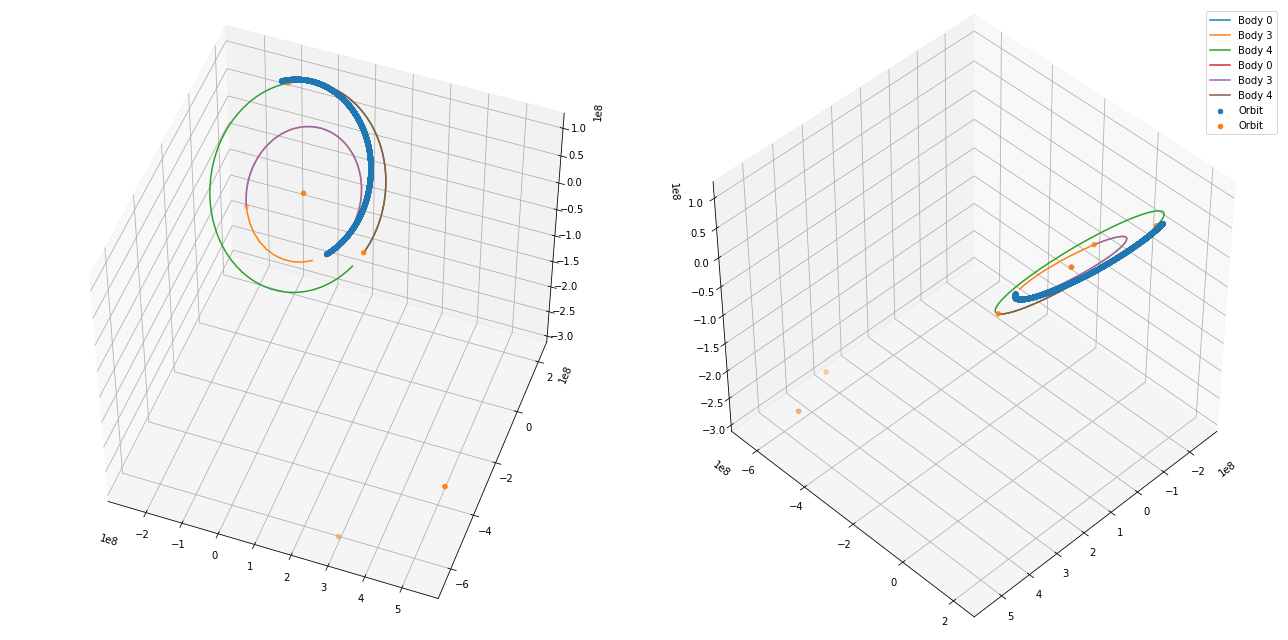

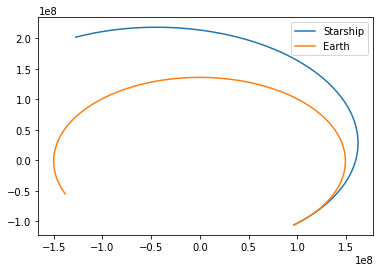

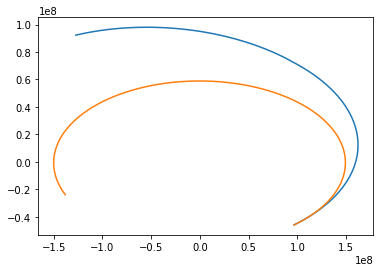

In [ ]:
starts = np.array([simulation_data['bodies_xyz'][o][0] for o in simulation_data['bodies_xyz']])
ends = np.array([simulation_data['bodies_xyz'][o][-1] for o in simulation_data['bodies_xyz']])

without_jupiter = simulation_data['bodies_xyz'].copy()
without_jupiter.pop(JUPITER, None)

orbits = get_orbits(mp.timestamp0, planets=without_jupiter.keys())
draw_orbits(orbits,
            without_jupiter,
            simulation_data['starship_xyz'],
            np.concatenate([starts, ends]))

plt.plot(simulation_data['starship_xyz'][:,0], simulation_data['starship_xyz'][:,1], label = "Starship")
plt.plot(simulation_data['bodies_xyz'][EARTH][:,0], simulation_data['bodies_xyz'][EARTH][:,1], label = "Earth")
plt.legend()
plt.show()
plt.plot(simulation_data['starship_xyz'][:,0], simulation_data['starship_xyz'][:,2], label = "Starship")
plt.plot(simulation_data['bodies_xyz'][EARTH][:,0], simulation_data['bodies_xyz'][EARTH][:,2], label = "Earth")
plt.show()
#plt.plot(simulation_data['starship_xyz'][:,1], simulation_data['starship_xyz'][:,2])
#plt.show()

#draw_orbits({'starship': simulation_data['starship_xyz'] - simulation_data['bodies_xyz'][EARTH]})
#
#min_mars_xyz
#
##draw_orbits(orbits, result_body_orbits, results[:,0:3])
#draw_orbits({'starship': earth_results})

In [ ]:
params_list = []
result_list = []
#Calculating for  [ 0.001441226   0.2146013794 -0.1598085462]
#Distance: 886363.7964514883

calc_simulation_data = {}
def calc_minimal_distance(params):
    global calc_simulation_data
    
    hohmann_diviation_angle, normal_burn_delta_v, delta_t = params
    mp = MissionProfile(
        timestamp0 = datetime.datetime(2020, 8, 3) +  datetime.timedelta(seconds = delta_t),
        v0 = np.sqrt(MU_EARTH / (200 + R_EARTH)) + 3.87, #4.3, #3.22 + 3.87,
        orbit0 = 200,
        mass0 = 1550,
        dry_mass = 120,
        duration = 60 * 60 * 24 * (30*8 + 15),
        sample_dt = 60 * 60,
        sample_size = 24*365*10,
        hohmann_diviation_angle=hohmann_diviation_angle,
        bodies = [SUN, EARTH, MARS, JUPITER],
        events = [
            Burn(t = 11500000,
                delta_v = normal_burn_delta_v,
                angle_orbital_plane_normal=90)
        ]
    )

    simulation_data = simulate(mp, log=False)
    distance = simulation_data['minimal_distances'][MARS]['distance']
    print("Distance:", '{:,}'.format(distance), "   ", params)
    
    params_list.append(params)
    result_list.append(distance)
    
    calc_simulation_data = simulation_data
    return distance

In [ ]:
#params = (1.4022439123e+02, 7.6867361677e-03)
#calc_minimal_distance(params)
#simulation_data = calc_simulation_data

In [ ]:
params = (75, 0.5, -60*60*24*2)
res = minimize(calc_minimal_distance, params, method='Nelder-Mead', tol=1e-6)
print(res)
print(res.x)

# Results without time
# [1.4022439123e+02 7.6867361677e-03]

KeyboardInterrupt: ignored

In [ ]:
# Distance: 16,586,424.436320035     [ 7.500e+01  5.000e-01 -1.728e+05]
# Distance: 14,034,391.160082463     [ 7.875e+01  5.000e-01 -1.728e+05]

In [ ]:
min_mars_xyz = simulation_data['minimal_distances'][MARS]['']
min_mars_starship_xyz = simulation_data['min_mars_starship_xyz']
distance = max(10000000, simulation_data['min_mars_distance'] * 15)
draw_orbits(orbits,
            simulation_data['bodies_xyz'],
            {'starship': simulation_data['starship_xyz']},
            np.concatenate([starts, ends]),
            np.concatenate([min_mars_xyz[np.newaxis,:], min_mars_starship_xyz[np.newaxis,:]]),
            focus_point = min_mars_xyz, focus_distance = distance,
            interactive=False)


In [ ]:
params_list = []
result_list = []
#Calculating for  [ 0.001441226   0.2146013794 -0.1598085462]
#Distance: 886363.7964514883
def calc_minimal_distance(params):
    a, b, c = params
    mp = MissionProfile(
        timestamp0 = datetime.datetime(2020, 6, 6),# +  datetime.timedelta(seconds = delta_t),
        v0 = 11.945,   # + start_delta_v, # 11.318 +  0.465 + 0.181,
        orbit0 = 240,
        mass0 = 1000, # TODO
        duration = 60 * 60 * 24 * 365,
        sample_dt = 60 * 60,
        sample_size = 24*365*10,
        #hohmann_diviation_angle=10,
#         events = [
#             InstantBurn(t = 60*60*24*30*3,
#                         delta_v = a,
#                         angle_orbital_plane = b,
#                         angle_orbital_plane_normal = c)
#         ]
    )
    print("Calculating for ", params)
    simulation_data = simulate(mp, log=False)
    distance = simulation_data['min_mars_distance']
    print("Distance:", distance)
    
    params_list.append(params)
    result_list.append(distance)
    
    return distance

In [ ]:
params = (-0.15, 0, 90)
res = minimize(calc_minimal_distance, params, method='Nelder-Mead', tol=1e-6)
print(res)
print(res.x)

In [ ]:
for i in range(len(params_list)):
    print("Params:   " + str(params_list[i]))
    print("Distance: " + str(result_list[i]))

## ODA solver

In [ ]:
system(pip install --upgrade pip)